# Playing Around With Fourier Transforms
We are following https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770

In [29]:
# Common imports
import os
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow.random import set_seed

from sklearn import preprocessing
from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

from scipy.fft import rfft

2024-03-12 01:10:04.826043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 01:10:05.348924: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-12 01:10:05.348944: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-03-12 01:10:05.427302: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 01:10:07.188112: W tensorflow/stream_executor/platform/de

### My little library of functions

I'll collect all functions at the top so I can copy them into a module easier.

In [2]:
def average_abs_fourier_transform(signal, num_buckets=1024):
    bucket_size = len(signal)//num_buckets
    assert(bucket_size == int(bucket_size))
    # calculate abs and reshape by buckets
    abs_signal = np.abs(signal)
    abs_signal = abs_signal.reshape(num_buckets,bucket_size)
    averaged = abs_signal.mean(axis=1)
    return averaged

In [3]:
def create_bucketed_fourier_transform(raw_data_path, preprocessed_data_path, num_buckets):
    merged_data = pd.DataFrame()
    for ix, filename in enumerate(os.listdir(raw_data_path)):
        dataset=pd.read_csv(os.path.join(data_dir, raw_path_end, filename), sep='\t')
        all_transforms = []
        for i in range(dataset.shape[1]):
            vibrations_over_time = dataset.iloc[:,i]
            fourier_transform = rfft(vibrations_over_time.to_numpy())
            averaged_transform = average_abs_fourier_transform(fourier_transform[:10240],num_buckets=num_buckets)
            all_transforms.append(averaged_transform)
        features = np.concatenate(all_transforms)
        features = pd.DataFrame(features.reshape(1,-1))
        features.index = [filename]
        merged_data = pd.concat([merged_data, features])

    col_names = []
    for i in range(1,dataset.shape[1]+1):
        for j in range(1,num_buckets+1):
            col_names.append(f"Br_{i}_Bu_{j}")
    merged_data.columns = col_names

    merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
    merged_data = merged_data.sort_index()
    outfile = os.path.join(preprocessed_data_path, f'averaged_ft_{num_buckets}_buckets.csv')
    merged_data.to_csv(outfile, index_label = 'timestamp')
    print(f"Dataframe with averaged FT written to {outfile}")
    

### Processing Raw data if preprocessed data does not exist yet.
This file is assumed to be run from train_project_main/notebooks otherwise adapt file paths below.

In [10]:
data_dir = '../data/IMS_bearings'
raw_path_end = 'raw/2nd_test'
prepro_path_end = 'preprocessed/2nd_test'

raw_data_path = os.path.join(data_dir, raw_path_end)
preprocessed_data_path = os.path.join(data_dir, prepro_path_end)
bucket_sizes = [2**i for i in range(4,11)]

In [5]:
for size in bucket_sizes:
    create_bucketed_fourier_transform(raw_data_path,preprocessed_data_path,size)

Dataframe with averaged FT written to ../data/IMS_bearings/preprocessed/2nd_test/averaged_ft_1024_buckets.csv


## Working with the preprocessed data

In [197]:
EXPONENT = 10

bucket_size = 2**EXPONENT

ft_df = pd.read_csv(os.path.join(data_dir, prepro_path_end, f'averaged_ft_{bucket_size}_buckets.csv'), )
ft_df.set_index('timestamp', inplace=True)
ft_df.head()

,Br_1_Bu_1,Br_1_Bu_2,Br_1_Bu_3,Br_1_Bu_4,Br_1_Bu_5,Br_1_Bu_6,Br_1_Bu_7,Br_1_Bu_8,Br_1_Bu_9,Br_1_Bu_10,...,Br_4_Bu_1015,Br_4_Bu_1016,Br_4_Bu_1017,Br_4_Bu_1018,Br_4_Bu_1019,Br_4_Bu_1020,Br_4_Bu_1021,Br_4_Bu_1022,Br_4_Bu_1023,Br_4_Bu_1024
timestamp,,,,,,,,,,,,,,,,,,,,,
2004-02-12 10:32:39,26.903135,6.203763,5.886258,13.891067,16.603897,30.420894,18.863562,13.506305,10.101365,9.089730,...,2.413372,2.242153,2.272921,2.858743,3.311524,2.797489,2.532701,3.342709,2.357315,2.958439
2004-02-12 10:42:39,9.216937,6.315469,7.504716,17.763260,20.577673,22.916778,15.058586,12.584818,7.478566,5.874054,...,3.043304,2.954317,2.084242,2.422959,2.097078,3.743464,2.948348,3.241554,4.115358,3.748754
2004-02-12 10:52:39,10.034218,6.560449,8.257709,26.396964,21.925208,28.252620,17.133095,8.602140,5.727607,8.133686,...,2.382865,2.900384,2.151955,3.258620,2.638877,4.034395,3.130111,3.440952,3.199771,3.311696
2004-02-12 11:02:39,10.307343,7.122653,7.518232,27.912910,20.212758,24.370686,19.222154,8.422242,6.342378,6.950195,...,3.071854,2.433580,2.363123,2.148055,2.987262,3.232365,3.436025,3.177865,3.217903,2.776066
2004-02-12 11:12:39,10.377186,6.150531,10.122263,22.547205,18.036845,23.728728,17.514555,8.589294,7.491661,7.208643,...,2.283760,2.896715,2.909494,3.111832,2.192142,3.211142,2.813883,4.138529,3.182723,3.340959


### Split into "normal" and "mixed" behavior

In [198]:
dataset_train = ft_df.iloc[:222]
dataset_test = ft_df[222:]

In [199]:
dataset_train.shape, dataset_test.shape 

((222, 4096), (762, 4096))

In [200]:
#dataset_train.plot(figsize = (12,6))

In [201]:
#ax = dataset_test.iloc[-285:-50,:].plot(figsize = (12,3))

In [202]:
#ax = dataset_test.iloc[:-285,:].plot(figsize = (12,3) )

### Normalize data

In [203]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)

X_full = pd.DataFrame(scaler.transform(ft_df), 
                             columns=dataset_test.columns, 
                             index=ft_df.index)


In [ ]:
def split_and_

## Defining the autoencoder

In [204]:
seed(10)
set_seed(10)
act_func = 'elu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(5*EXPONENT,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(EXPONENT,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(5*EXPONENT,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=100
BATCH_SIZE=10

In [205]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 50)                204850    
                                                                 
 dense_29 (Dense)            (None, 10)                510       
                                                                 
 dense_30 (Dense)            (None, 50)                550       
                                                                 
 dense_31 (Dense)            (None, 4096)              208896    
                                                                 
Total params: 414,806
Trainable params: 414,806
Non-trainable params: 0
_________________________________________________________________


In [206]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience=10)

history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1,
                 callbacks = [es])

Epoch 1/100
21/21 [==============================] - 1s 13ms/step - loss: 0.1149 - val_loss: 0.0385
Epoch 2/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0359 - val_loss: 0.0337
Epoch 3/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0338 - val_loss: 0.0333
Epoch 4/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0336 - val_loss: 0.0334
Epoch 5/100
21/21 [==============================] - 0s 6ms/step - loss: 0.0336 - val_loss: 0.0333
Epoch 6/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0336 - val_loss: 0.0334
Epoch 7/100
21/21 [==============================] - 0s 6ms/step - loss: 0.0336 - val_loss: 0.0333
Epoch 8/100
21/21 [==============================] - 0s 6ms/step - loss: 0.0335 - val_loss: 0.0334
Epoch 9/100
21/21 [==============================] - 0s 6ms/step - loss: 0.0336 - val_loss: 0.0334
Epoch 10/100
21/21 [==============================] - 0s 6ms/step - loss: 0.0337 - val_loss: 0.0333
Epoch 11

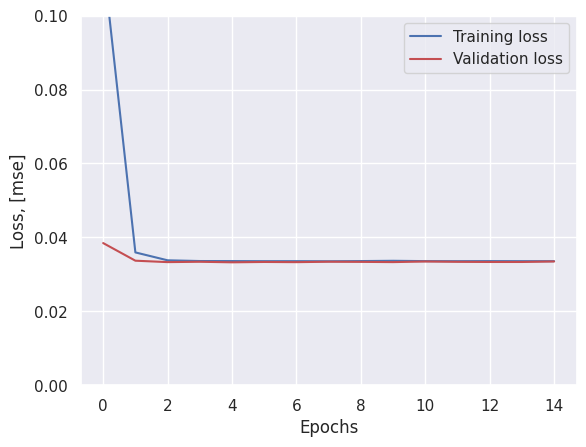

In [207]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.1])
plt.show()

In [208]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)

7/7 [==============================] - 0s 3ms/step


/tmp/ipykernel_218907/4095504646.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['loss_mae'],


(0.0, 0.5)

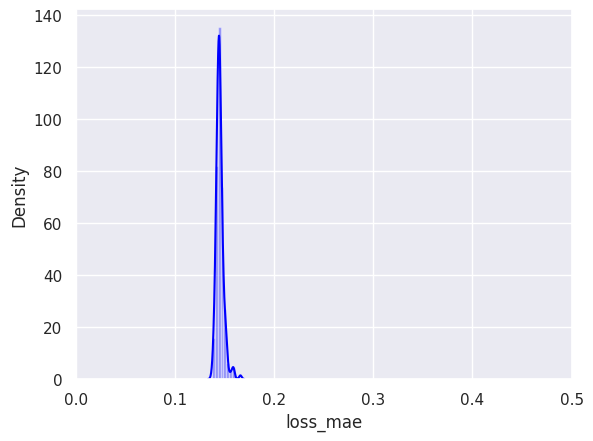

In [209]:
scored['loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.5])

In [216]:
threshold = 0.19
threshold

0.19

In [217]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['threshold'] = threshold
scored['anomaly'] = scored['loss_mae'] > scored['threshold']
scored.sort_index(inplace=True)
scored

24/24 [==============================] - 0s 3ms/step


,loss_mae,threshold,anomaly
timestamp,,,
2004-02-13 23:32:39,0.143401,0.19,False
2004-02-13 23:42:39,0.143897,0.19,False
2004-02-13 23:52:39,0.145325,0.19,False
2004-02-14 00:02:39,0.144401,0.19,False
2004-02-14 00:12:39,0.142303,0.19,False
...,...,...,...
2004-02-19 05:42:39,3.096529,0.19,True
2004-02-19 05:52:39,1.712595,0.19,True
2004-02-19 06:02:39,1.833337,0.19,True


In [218]:
scored.anomaly.value_counts()

anomaly
False    479
True     283
Name: count, dtype: int64

In [219]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['threshold'] = threshold
scored_train['anomaly'] = scored_train['loss_mae'] > scored_train['threshold']
scored = pd.concat([scored_train, scored])
scored

7/7 [==============================] - 0s 3ms/step


,loss_mae,threshold,anomaly
timestamp,,,
2004-02-12 10:32:39,0.166104,0.19,False
2004-02-12 10:42:39,0.159019,0.19,False
2004-02-12 10:52:39,0.159623,0.19,False
2004-02-12 11:02:39,0.158639,0.19,False
2004-02-12 11:12:39,0.155401,0.19,False
...,...,...,...
2004-02-19 05:42:39,3.096529,0.19,True
2004-02-19 05:52:39,1.712595,0.19,True
2004-02-19 06:02:39,1.833337,0.19,True


In [220]:
scored[scored.anomaly == True]

,loss_mae,threshold,anomaly
timestamp,,,
2004-02-17 07:22:39,0.196192,0.19,True
2004-02-17 07:32:39,0.262657,0.19,True
2004-02-17 07:42:39,0.266354,0.19,True
2004-02-17 07:52:39,0.275309,0.19,True
2004-02-17 08:02:39,0.277920,0.19,True
...,...,...,...
2004-02-19 05:42:39,3.096529,0.19,True
2004-02-19 05:52:39,1.712595,0.19,True
2004-02-19 06:02:39,1.833337,0.19,True


<AxesSubplot:xlabel='timestamp'>

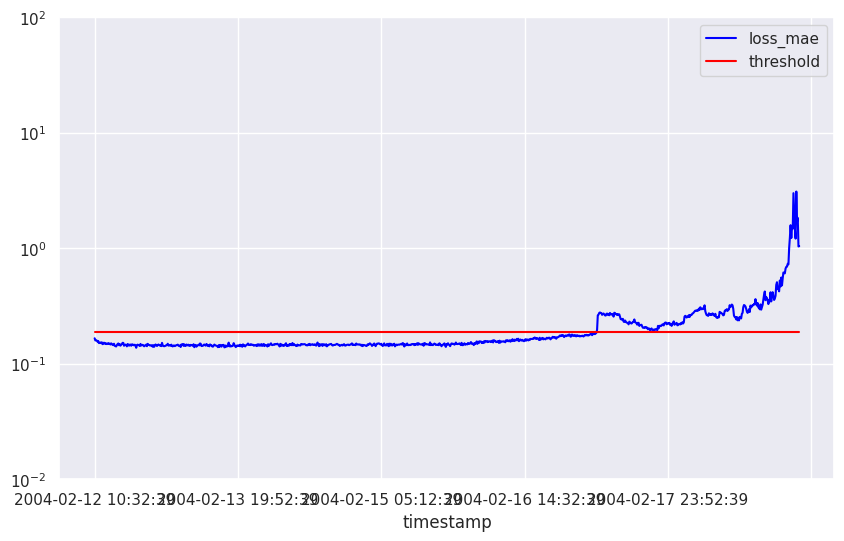

In [221]:
scored.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])

### Package the predictions for model evaluation and package the model for cloud upload.

In [196]:
bucket_size = 2**EXPONENT

scored.to_pickle(f"data/averaged_ft_{bucket_size}_buckes_experiment_2.pkl")


# Creating a baseline model based on classic vibration thresholds

Simple idea: 
Train model by observing maximum of mean deviations per bearing. 
Then for each data point: 
    - calculate percentage of max seen so far per bearing and max of that
    - decide on threshold between 1 and infinity to decide on warning

In [30]:
X_full.iloc[0,:].max()

0.8182867547838502

In [31]:
def calculate_relative_vibrations(df):
    
    loss = []
    for i in range(len(df)):
        loss.append(abs(X_full.iloc[i,:].max()))
    return pd.DataFrame({'loss':loss}, index=df.index)
    

In [32]:
relative_vibes = calculate_relative_vibrations(X_full)

In [33]:
relative_vibes.to_pickle("data/classic_thresholding_prediction_experiment_2.pkl")